# PROJET DATA MINING : Les meilleurs films de tous les temps 

IMBd est un site qui regroupe de nombreuse information sur beaucoup de film, dont des listes de films par genre, par décennies, etc. Pour ce projet on va s'intéresser à une liste des meilleurs films de tous les temps crée par un utilisateur d'IMBd. La liste n'est pas subjective, elle est basée sur différents critéres comme la réalsation, le succès du film en général ou le scénario.La liste a été crée en décembre 2012 et mis à jour en mars 2017, bien que le film le plus récent date de 2003 et que le plus vieux de 1930.
Le but est de collecter des données de la liste grâce au web scraping et aprés nettoyage de faire quelques statistiques descriptives.




In [1]:
##!pip install plotly
##!pip install lxml

 ## Importations de librairies 

In [2]:
import os, requests, bs4, re, collections
import lxml
import warnings; warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

# I/ Web Scraping

### A) récupération de l'url de la liste des films 

In [3]:
web_page_url = "https://www.imdb.com/list/ls055592025/"
web_page_response = requests.get(web_page_url)
web_page_response.status_code
soup = bs4.BeautifulSoup(web_page_response.content)

### B) Récupération des balises "div" class "lister-item mode-detail"

Les balises "div" class "lister-item mode-detail" comportent les données qui nous intéresse comme la note, le classement et les genres des films

In [4]:
movies = soup.find_all(name= "div", class_= "lister-item mode-detail")

### C) Création de la table table_movie

In [5]:
table_movie = pd.DataFrame(columns = ["Année", "Note", "Classement", "Durée (en min)",  "Genre"])
for index, a_movie in enumerate(movies):
    tmp_année = a_movie.find(name = "span", class_="lister-item-year text-muted unbold").get_text()
    tmp_note = a_movie.find(name = "span", class_="ipl-rating-star__rating").get_text()
    tmp_durée = a_movie.find(name = "span", class_="runtime").get_text() 
    tmp_genre = a_movie.find(name = "span", class_="genre").get_text() 
    tmp_classement = a_movie.find(name = "span", class_="lister-item-index unbold text-primary").get_text()
     
    tmp_url = ""
    if tmp_classement:
        tmp_url = tmp_classement[0]
    table_movie.loc[index,:] = [tmp_année, tmp_note, tmp_classement, tmp_durée, tmp_genre]
table_movie

,Année,Note,Classement,Durée (en min),Genre
0,(1972),9.2,1.,175 min,"\nCrime, Drama"
1,(1994),9.3,2.,142 min,\nDrama
2,(1993),9,3.,195 min,"\nBiography, Drama, History"
3,(1980),8.2,4.,129 min,"\nBiography, Drama, Sport"
4,(1942),8.5,5.,102 min,"\nDrama, Romance, War"
...,...,...,...,...,...
95,(1954),8.5,96.,112 min,"\nMystery, Thriller"
96,(1949),8.1,97.,104 min,"\nFilm-Noir, Mystery, Thriller"
97,(1955),7.7,98.,111 min,\nDrama
98,(1959),8.3,99.,136 min,"\nAdventure, Mystery, Thriller"


# II/ Nettoyage des données 

In [6]:
table_movie.dtypes

Année             object
Note              object
Classement        object
Durée (en min)    object
Genre             object
dtype: object

### A) L'année 

In [7]:
tmp_date_list = table_movie["Année"].values.tolist()
for i in range(len(tmp_date_list)):
    tmp_date_list[i] = tmp_date_list[i].replace("(", "")   # on supprime les parenthéses 
    tmp_date_list[i] = tmp_date_list[i].replace(")", "")
    tmp_date_list[i] = int(tmp_date_list[i])               # on transforme les données en nombre entier
table_movie["Année"] = tmp_date_list

### B) Les notes

In [8]:
tmp_note_list = table_movie["Note"].values.tolist()
for i in range(len(tmp_note_list)):
    tmp_note_list[i] = float(tmp_note_list[i])          # on s'assure que les notes soit bien des nombres à virgules
table_movie["Note"] = tmp_note_list

### C) Le classement 

In [9]:
tmp_classement_list = table_movie["Classement"].values.tolist()
for i in range(len(tmp_classement_list)):
    tmp_classement_list[i] = tmp_classement_list[i].replace(".", "")  # on supprime les points 
    tmp_classement_list[i] = int(tmp_classement_list[i])              # on transforme les données en nombres entiers
table_movie["Classement"] = tmp_classement_list

### D) La durée

In [10]:
tmp_duree_list = table_movie["Durée (en min)"].values.tolist()
for i in range(len(tmp_duree_list)):
    tmp_duree_list[i] = tmp_duree_list[i].replace(" min", "")
    tmp_duree_list[i] = tmp_duree_list[i].replace(" ", "")
    tmp_duree_list[i] = int(tmp_duree_list[i])
table_movie["Durée (en min)"] = tmp_duree_list

###  E) Les genres

In [11]:
tmp_genre_list = table_movie["Genre"].values.tolist()
for i in range(len(tmp_genre_list)):
    tmp_genre_list[i] = tmp_genre_list[i].replace("\n", "")
    tmp_genre_list[i] = tmp_genre_list[i].replace("-", "_")
    tmp_genre_list[i] = tmp_genre_list[i].replace(" ", "")
    tmp_genre_list[i] = tmp_genre_list[i].replace(",", " ")
table_movie["Genre"] = tmp_genre_list

On va maintenant séparer les genres, en effet quand on les récupère sur le site web ils sont réunis dans une liste. Un film a entre 1 et 3 genres. Il y a 20 genres de films différents en tout : Crime, Drama, Biography, History, Sport, Romance, War, Mystery, Adventure, Family, Fantasy, Thriller, Horror, Film-noir, Musical, Action, Sci-fi, Comedy, Music, et Western. On va donc créer une liste pour chaque genre, avec 1 si le film est du genre concerné, 0 sinon.

In [12]:
# On récupère les données des listes "Classement" et "Genre"

Classement = table_movie["Classement"].values.tolist()
Genre = table_movie["Genre"].values.tolist()

# On crée des liste vides afin de les complèter plus tard
Crime = [0] * 100
Drama  = [0] * 100
Biography = [0] * 100
History = [0] * 100
Sport = [0] * 100
Romance  = [0] * 100
War = [0] * 100
Mystery = [0] * 100
Adventure = [0] * 100
Family = [0] * 100
Fantasy = [0] * 100
Thriller = [0] * 100
Horror = [0] * 100
Film_noir = [0] * 100
Musical = [0] * 100
Action = [0] * 100
Sci_fi = [0] * 100
Comedy = [0] * 100
Music = [0] * 100
Western = [0] * 100


# On crée un Dataframe avec les listes crée précédemment.
# La liste "Classement" permettra de faire une jointure avec le premier Dataframe plus tard.

table_genre = pd.DataFrame({"Classement" : Classement, 
                     "Genre" : Genre,
                     "Crime": Crime,
                     "Drama" : Drama,
                     "Biography": Biography,
                     "History": History,
                     "Sport" : Sport,
                     "Romance": Romance ,
                     "War" : War,
                     "Mystery"  : Mystery ,
                     "Adventure" : Adventure,
                     "Family": Family,
                     "Fantasy" :Fantasy,
                     "Thriller" : Thriller,
                     "Horror" : Horror,
                     "Film_noir" : Film_noir,
                     "Musical" :Musical ,
                     "Action" : Action,
                     "Sci_fi" : Sci_fi,
                     "Comedy" : Comedy ,
                     "Music" : Music,
                     "Western" : Western})


In [13]:
# On récupere les valeurs des colonnes qui nous interresse

List_genre = table_genre["Genre"].values.tolist() 
Crime = table_genre["Crime"].values.tolist()
Drama = table_genre["Drama"].values.tolist()
Biography = table_genre["Biography"].values.tolist()
History = table_genre["History"].values.tolist()
Sport = table_genre["Sport"].values.tolist()
Romance = table_genre["Romance"].values.tolist()
War = table_genre["War"].values.tolist()
Mystery = table_genre["Mystery"].values.tolist()
Adventure = table_genre["Adventure"].values.tolist()
Family = table_genre["Family"].values.tolist()
Fantasy = table_genre["Fantasy"].values.tolist()
Thriller = table_genre["Thriller"].values.tolist()
Horror = table_genre["Horror"].values.tolist()
Film_noir = table_genre["Film_noir"].values.tolist()
Musical = table_genre["Musical"].values.tolist()
Action = table_genre["Action"].values.tolist()
Sci_fi = table_genre["Sci_fi"].values.tolist()
Comedy = table_genre["Comedy"].values.tolist()
Music = table_genre["Music"].values.tolist()
Western = table_genre["Western"].values.tolist()

In [14]:
# On attribue 1 si le film est du genre correspondant 

for i in range(len(List_genre)):
    if "Crime" in  Genre[i]: 
        Crime[i] = 1
    if "Drama" in  Genre[i]:
        Drama[i] = 1
    if  "Biography" in Genre[i]:
        Biography[i] = 1
    if "History" in  Genre[i]:
        History[i] = 1
    if "Sport" in  Genre[i]:
        Sport[i] = 1 
    if "Romance" in  Genre[i]:
        Romance[i] = 1
    if "War" in  Genre[i]:
        War[i] =1
    if "Mystery" in  Genre[i]:
        Mystery[i] =1
    if "Adventure" in  Genre[i]:
        Adventure[i] =1
    if  "Family" in  Genre[i]:
        Family[i] =1
    if "Fantasy" in  Genre[i]:
        Fantasy[i] =1
    if  "Thriller" in  Genre[i]:
        Thriller[i] =1
    if  "Horror" in  Genre[i]:
        Horror[i] =1
    if "Film_Noir" in  Genre[i] :
        Film_noir[i] =1
    if  "Musical" in  Genre[i]:
        Musical[i] =1
    if  "Action" in  Genre[i] :
        Action[i] =1
    if  "Sci_Fi"in  Genre[i] :
        Sci_fi[i] =1
    if  "Comedy" in  Genre[i]:
        Comedy[i] =1
    if "Music" in  Genre[i] :
        Music[i] =1
    if "Western" in  Genre[i]:
        Western[i] =1
        

# Maontenent on remplace les valeurs obtenues dans les listes crée précedemment

table_genre["Crime"] = Crime 
table_genre["Drama"] = Drama
table_genre["Biography"] = Biography
table_genre["History"] = History
table_genre["Sport"] = Sport
table_genre["Romance"] = Romance 
table_genre["War"] = War
table_genre["Mystery"] = Mystery
table_genre["Adventure"] = Adventure
table_genre["Family"] = Family
table_genre["Thriller"] = Thriller
table_genre["Fantasy"] = Fantasy
table_genre["Horror"] = Horror
table_genre["Film_noir"] = Film_noir
table_genre["Musical"] = Musical
table_genre["Action"] = Action
table_genre["Sci_fi"] = Sci_fi
table_genre["Comedy"] = Comedy
table_genre["Music"] = Music
table_genre["Western"] = Western
table_genre

,Classement,Genre,Crime,Drama,Biography,History,Sport,Romance,War,Mystery,...,Fantasy,Thriller,Horror,Film_noir,Musical,Action,Sci_fi,Comedy,Music,Western
0,1,Crime Drama,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Drama,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Biography Drama History,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Biography Drama Sport,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Drama Romance War,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Mystery Thriller,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
96,97,Film_Noir Mystery Thriller,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
97,98,Drama,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,99,Adventure Mystery Thriller,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [15]:
#Fusion des 2 tables en fonction du classement
del table_movie["Genre"]
del table_genre["Genre"]
final = pd.merge(table_movie ,table_genre, on = "Classement")
final.head()

,Année,Note,Classement,Durée (en min),Crime,Drama,Biography,History,Sport,Romance,...,Fantasy,Thriller,Horror,Film_noir,Musical,Action,Sci_fi,Comedy,Music,Western
0,1972,9.2,1,175,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1994,9.3,2,142,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1993,9.0,3,195,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1980,8.2,4,129,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1942,8.5,5,102,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
final.dtypes

Année               int64
Note              float64
Classement          int64
Durée (en min)      int64
Crime               int64
Drama               int64
Biography           int64
History             int64
Sport               int64
Romance             int64
War                 int64
Mystery             int64
Adventure           int64
Family              int64
Fantasy             int64
Thriller            int64
Horror              int64
Film_noir           int64
Musical             int64
Action              int64
Sci_fi              int64
Comedy              int64
Music               int64
Western             int64
dtype: object

On a maintenent notre base de données propre, on peut donc passer aux statistiques descriptives. 

# Statistiques descriptives

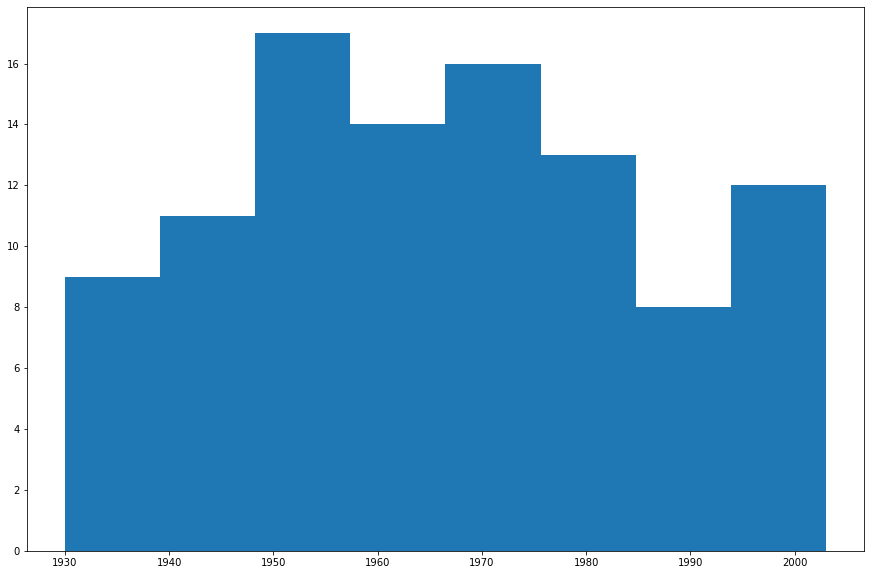

In [27]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.hist(final["Année"], bins = 8)

plt.show()

Le film le plus vieux de la liste date de 1930, qui est "À l'Ouest rien de nouveau" tandis que le plus récent, "Le Seigneur des anneaux : Le Retour du roi" ,est sortie en 2003. On remarque que 2 décennies sortent du lot comparé aux autres, les années 50 qui comptent 20 films et les années 70 avec 19 films. Les décennies les plus pauvres sont les années 2000 avec seulement 3 films et les années 80 avec 7 films.

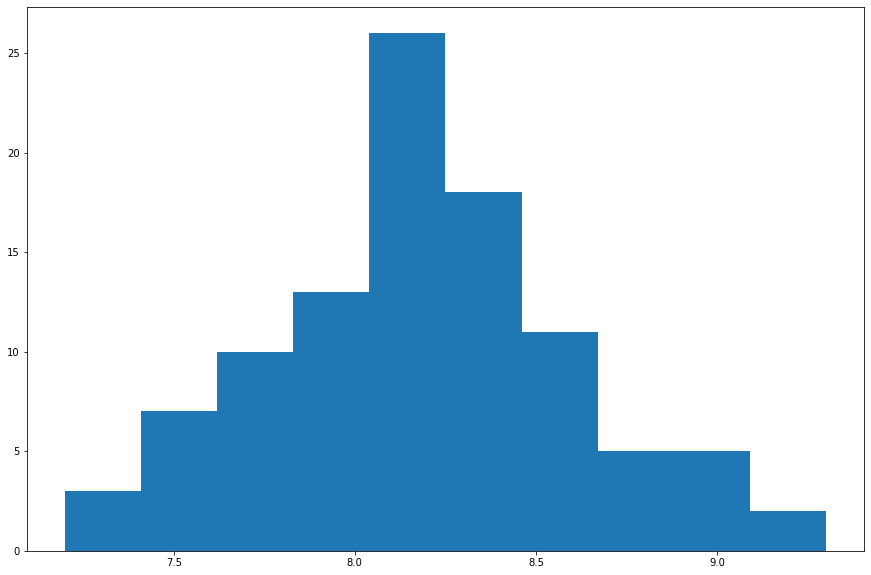

In [24]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.hist(final["Note"])
plt.show()

La meilleur note de la liste est 9.3 pour le film "Les Évadés" et la note la plus faible du top est de 7.2 pour le film "Un Américain à Paris". On voit qu'une grande majorité des films ont une note entre 8 et 8.3.

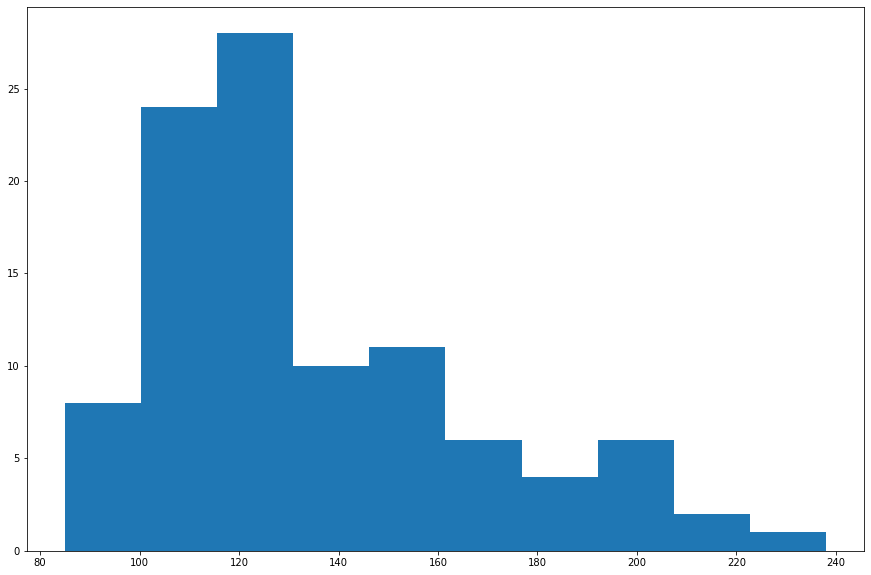

In [29]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.hist(final["Durée (en min)"])
plt.show()

La majorité des films de la liste ont une durée entre 100 et 140 minutes. Le fim le plus long de la liste est "Autant en emporte le vent" avec 238 minutes

In [20]:
Sum_genre = [0] * 20
Sum_genre[0] = table_genre["Crime"].sum()
Sum_genre[1] = table_genre["Drama"].sum()
Sum_genre[2] = table_genre["Biography"].sum()
Sum_genre[3] =table_genre["History"].sum()
Sum_genre[4] =table_genre["Sport"].sum()
Sum_genre[5] =table_genre["Romance"].sum()
Sum_genre[6] =table_genre["War"].sum()
Sum_genre[7] =table_genre["Mystery"].sum()
Sum_genre[8] =table_genre["Adventure"].sum()
Sum_genre[9] =table_genre["Family"].sum()
Sum_genre[10] =table_genre["Thriller"].sum()
Sum_genre[11] =table_genre["Fantasy"].sum()
Sum_genre[12] =table_genre["Horror"].sum()
Sum_genre[13] =table_genre["Film_noir"].sum()
Sum_genre[14] =table_genre["Musical"].sum()
Sum_genre[15] =table_genre["Action"].sum()
Sum_genre[16] =table_genre["Sci_fi"].sum()
Sum_genre[17] =table_genre["Comedy"].sum()
Sum_genre[18] =table_genre["Music"].sum()
Sum_genre[19] =table_genre["Western"].sum()


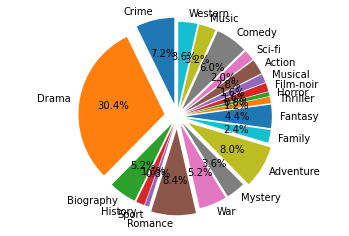

In [21]:
labels= ["Crime", "Drama", "Biography","History","Sport","Romance" ,"War","Mystery","Adventure","Family","Fantasy",
         "Thriller","Horror","Film-noir", "Musical", "Action" ,"Sci-fi" ,"Comedy", "Music" ,"Western"]


explode = (0.15, 0.15, 0.10, 0.10, 0.10, 0.15 ,0.10, 0.10, 0.15, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10,
           0.10)

plt.pie(Sum_genre, labels = labels
        , explode = explode
        ,autopct='%1.1f%%'
        ,startangle=90 
        
       )
plt.axis('equal')
plt.show()

Un genre prédomine clairement, quasiment un film sur 3 est un drama, c'est le genre le plus répandu dans cette liste. Ensuite nous avons le genre Romance avec 8.4% et les genres Crime et Adventure qui sont tout les 2 à 7.2%. Les genre les moins présent sont Sport et Horror avec 2%.




#  Conclusion 


Grâce au web scraping j'ai pu récupérer des données précises et détaillées d'une liste de film sur le site IMDb. Après avoir nettoyer les données, j'ai pu faire des statistiques descriptives et voir par exemple quel genre etait le plus commun dans les meilleurs films ou quelle décennie a été la plus prolifique en terme de bons films.



Merci.



HIVERT Mathieu 